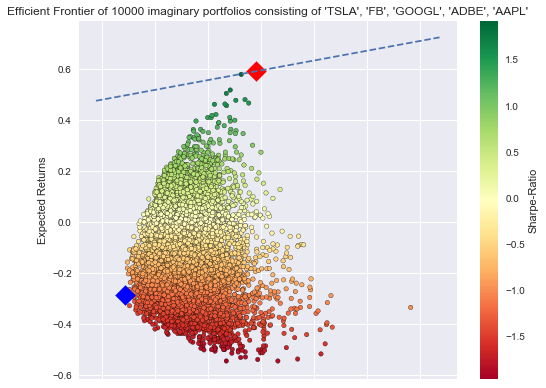

In [36]:
# Copied from: https://medium.com/python-data/effient-frontier-in-python-34b0c3043314
# This program was created for my own educational purposes to truly understand Markowitz Portfolio Theory
# No part of this program is used for commercial purposes

import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

quandl.ApiConfig.api_key = '3qNsf3VUNsvytS7sS_7W'
selected = ['TSLA', 'FB', 'GOOGL', 'ADBE', 'AAPL']
data = quandl.get_table('WIKI/PRICES', ticker = selected, qopts = { 'columns': ['date', 'ticker', 'adj_close'] }, date = { 'gte': '2018-1-1', 'lte': '2018-12-31' }, paginate=True)

clean = data.set_index('date')
table = clean.pivot(columns='ticker')

# Calculate daily & annual returns of the stocks
returns_daily = table.pct_change()
returns_annual = returns_daily.mean() * 252 # of Trading Days: 252

# print(returns_daily.head())
# print(returns_annual.head())

# Calculate daily & annual covariance
cov_daily = returns_daily.cov() # Generate covariance matrix
cov_annual = cov_daily * 252 # Annualize covmat

# Risk Free Return Rate
risk_free = 0.02 

# Lists to store portfolio attributes
port_returns = []
port_volatility = []
stock_weight = []
sharpe_ratio = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolio = 10000 # Number of imaginary portfolios

# Populate empty lists with each port's attributes
for port in range(num_portfolio):
    weights = np.random.random(num_assets) # Returned as n x 1 Matrix
    weights /= np.sum(weights) # Normalize weight
    returns = np.dot(weights, returns_annual) # Portfolio Expected Return
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights))) # Portfolio Standard Deviation

    # Calculate Sharpe Ratio
    sharpe = (returns - risk_free) / volatility
    sharpe_ratio.append(sharpe)
    
    # Add calculated values into appropriate lists
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weight.append(weights)
    
portfolio = {
    'Returns': port_returns,
    'Volatility': port_volatility,
    'Sharpe-Ratio': sharpe_ratio
}

# extend portfolio to accomodate ticker & weight
for counter, symbol in enumerate(selected):
    portfolio[symbol + ' Weight'] = [Weight[counter] for Weight in stock_weight]

df = pd.DataFrame(portfolio)

column_order = ['Returns', 'Volatility', 'Sharpe-Ratio'] + [stock + ' Weight' for stock in selected]

df = df[column_order]

# Calculate min_vol and max_SR
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe-Ratio'].max()

sharpe_portfolio = df.loc[df['Sharpe-Ratio'] == max_sharpe]
min_variance_portfolio = df.loc[df['Volatility'] == min_volatility]

plt.style.use('seaborn')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe-Ratio', cmap='RdYlGn', edgecolors='black', grid=True)
# Plot minimum variance portfolio
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
# Plot tangent portfolio
plt.scatter(x=min_variance_portfolio['Volatility'], y=min_variance_portfolio['Returns'], c='blue', marker='D', s=200)
# Plot the Capital Allocation Line
axes = plt.gca()
x_vals = np.array(axes.get_xlim())
plt.plot(x_vals, risk_free + (max_sharpe * x_vals), '--')
plt.xlabel('Volatility')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier of ' + str(num_portfolio) + ' imaginary portfolios consisting of ' + str(selected).strip('[]'))
plt.tight_layout()
plt.show()